# BAKU - Fine Tuning with IA3
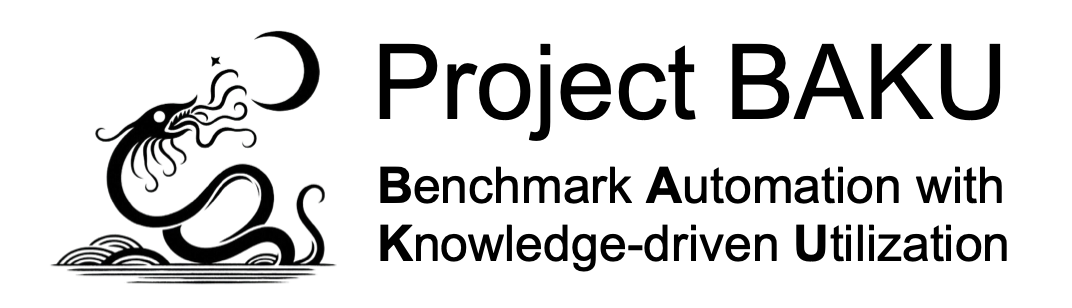

This notebook is fine-tuning language models (LLMs). The adapter used are IA3 and LoRA. The dataset is setup with 600 examples, in two classes, input and output.

### Imports & Setup

In [ ]:
!pip install transformers #library of often use llms
!pip install datasets
!pip install evaluate
!pip install trl
!pip install peft
!pip install accelerate

In [ ]:
!pip install bitsandbytes
!pip install -U bitsandbytes

In [3]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoConfig,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
) #the model

import torch #for the model

import numpy as np #to better use of the arrays

import matplotlib.pyplot as plt #plots

import pandas as pd #for csv

import evaluate #for evaluation

from peft import PeftModel, PeftConfig, get_peft_model, IA3Config, TaskType, prepare_model_for_kbit_training #PEFT

from peft import TaskType

from datasets import load_dataset, DatasetDict, Dataset #Dataset loader

from torch.nn import functional as F
import torch

from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM, DataCollatorForCompletionOnlyLM

from google.colab import drive #to import the csv and other data
from google.colab import auth
from google.colab import userdata
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
import json


import string
import random
import os
import time

In [4]:
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [5]:
model_name = "deepseek-ai/deepseek-coder-1.3b-instruct"

data_folder = "/content/drive/MyDrive/Colab_Notebooks/Baku/data/"
data_folder_id = ""

outputs_folder = data_folder+"final_model_DeepSeekV1_1TB_dts"

model_folder = "final_model_DeepSeekV1_1TB"

data_loss = data_folder+model_folder+"training_logs.csv"

data_files = {"train" : data_folder+"training.jsonl", "test": data_folder+"testing.jsonl", "eval": data_folder+"evaluating.jsonl"}
dataset = load_dataset("json",data_files=data_files) #sample size 200

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

### Classes

In [6]:
class DataLoader:
    def __init__(self, data_path:str):
        try:
            self.data_path = data_path
            self.dataframe = pd.read_csv(data_path)
            print("Data Loaded.")
        except:
            raise Exception("Data couldn't be loaded.")


    def save(self):#Save the modified csv
        try:
            self.dataframe.to_csv(self.data_path, index=False)
            print("All data updated.")
        except:
            raise Exception("Data couldn't be uploaded.")

    def column_values(self,column_name):#Get a list of values in a column
        try:
            return self.dataframe[column_name].values
        except:
            raise Exception("Column must be wrong.")

    def new_row(self, new_values: list):#Matches two list to form a new data row
      if len(new_values) != len(self.dataframe.columns):
          raise ValueError("The number of values does not match the number of columns.")

      # Create a DataFrame from the new row values
      new_row = pd.DataFrame([dict(zip(self.dataframe.columns, new_values))])

      self.dataframe = pd.concat([self.dataframe, new_row], ignore_index=True)

    def update_row(self,index: str, new_values:list):
        if len(new_values) != len(self.dataframe.columns):
            raise ValueError("The number of values does not match the number of columns.")
        self.dataframe = self.dataframe.set_index(index)
        self.dataframe.loc[new_values[0]] = new_values[1:]
        self.dataframe = self.dataframe.reset_index()


    def get_row(self, column: str, key: any):#Get all row using a key
        row = self.dataframe.set_index(column).loc[[key]]  # [[key]] to ensure good research
        values = row.values.flatten().tolist()
        return values

    def static_row_string(self,id,ignore_columns=""):#Choose a value to generate
        if(id==0):
            return "Impossible to pick the value."

        else:

            if not ignore_columns == "": #if there is a column...
                static = self.dataframe.drop(ignore_columns, axis=1).iloc[id]

            else:
                static = self.dataframe.iloc[id]

            static = static.to_string(index=False)
            return static

    def random_row_string(self,ignore_columns=""):#Random pick value to generates
        random = self.dataframe.sample()
        id = random.get('id').values[0]

        if not ignore_columns == "":#if there is a column...
            random = random.drop(ignore_columns, axis=1)

        random = random.to_string(index=False)
        return random,id


In [7]:
class CodeGeneration:

    def __init__(self,model,model_name,tokenizer,data : DataLoader,input_str: str,input_id : int,
                 max_length : int, base_code: str = "", topology="regression"):
        self.model = model
        self.model_name = model_name
        self.data = data
        self.input_str = input_str
        self.max_length = max_length
        self.input_id = input_id
        self.tokenizer = tokenizer
        self.base_code = base_code

        if topology == "performance":
            self.template = self.input_str

        elif topology == "regression":
            self.template = f"""
        Complete the following C code, {self.input_str}:
        {self.base_code}


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            {self.base_code}
            </Program>
        """


        self.dif_seconds = 0
        self.ouput = ""
        self.program_name = ""
        self.program = ""


    def generate_code(self,response=True):#Measure time and generate the code
        input_time = time.time()
        inputs = self.tokenizer(self.template, return_tensors="pt").to(self.model.device)
        outputs = self.model.generate(**inputs, max_length=self.max_length) #model output
        output_time = time.time()

        self.dif_seconds = (output_time - input_time) #time measure
        decoded_output = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        self.output = decoded_output

        if(response):
            print('The output was:' + decoded_output)
            print(f'Time spend in the code generation: {self.dif_seconds}')


    def get_output_list(self):#Return the data from the program generation
        if (self.program_name == "") or (self.program == ""):
            program = self.program_extratcion()

        if(self.base_code in self.program):#Do not accept base code as a generated code

            len_program = len(self.tokenizer.encode(self.program)) #count the amount of tokens in the program
            return [self.model_name,
                    self.dif_seconds,
                    self.program_name,
                    self.input_id,
                    -1]

        len_program = len(self.tokenizer.encode(self.program)) #count the amount of tokens in the program
        return [self.model_name,
                self.dif_seconds,
                self.program_name,
                self.input_id,
                len_program]


    def program_extratcion(self):#Return the program generated"
        self.name_generator()

        if self.program == "":
            final_program = ""
            suboutput_list = self.output.split("<Program>")

            for subprogram in (suboutput_list):
              if "</Program>" in subprogram:
                program = subprogram.split("</Program>")[0]

                if program.count('{') == program.count('}'):
                        final_program = program

            self.program = final_program

        return self.program


    def name_generator(self,size=4): #Randomly generate a new file name

        if self.program_name == "" :
            chars=string.ascii_uppercase + string.digits
            random_name = ''.join(random.choice(chars) for _ in range(size))
            while random_name in self.data.column_values('code_name'):
                random_name = ''.join(random.choice(chars) for _ in range(size))
            self.program_name = random_name




In [8]:

class CompilationEvalPipeline: #TODO: setup the file generation to local as well
    def __init__(
            self,
            model: object,
            model_name: str,
            tokenizer: object,
            parent_folder_id: str,
            parent_folder_name: str,
            child_folder: str,
            dataset: Dataset,
            topology: str = "performance"
        ):
        self.model = model
        self.model_name = model_name
        self.tokenizer = tokenizer
        self.dataset = dataset
        self.topology = topology

        try:
            folder_id, folder_name = Drive.find_folder(parent_folder_id,child_folder)
            if folder_id == None or folder_name == None:
                folder_id, folder_name = Drive.create_folder(parent_folder_id,child_folder)

            self.folder_id = folder_id

            print(parent_folder_name,folder_id,folder_name)

            sampling_path = parent_folder_name+folder_name+"/"+"sampling.csv"
            models_path = parent_folder_name+folder_name+"/"+"models_codes.csv"

            sampling = pd.DataFrame(columns=["model","mean_seconds","std_seconds","sample_size"
                                            ,"max_length","lower_value","higher_value"])
            sampling.to_csv(sampling_path,index=False)

            models = pd.DataFrame(columns=["model_name","seconds","code_name","caracteristcs"
                                            ,"length"])
            models.to_csv(models_path,index=False)


            self.models_data = DataLoader(models_path)
            self.sampling_data = DataLoader(sampling_path)
        except Exception as e:
            raise f"Folder coulnd't been created: {e}"



    def eval_code_generation(self, max_len: int, dataset_flag: str = "train", i: int = 0,model_type="base") -> float:#Single Program Generation
        try:

            code_folder = f"code_{model_type}"
            code_folder_id, code_folder_name = Drive.find_folder(self.folder_id,code_folder)

            if code_folder_id == None or code_folder_name == None:
                code_folder_id, code_folder = Drive.create_folder(self.folder_id,code_folder)

            generator = CodeGeneration(
            model=self.model,
            model_name=self.model_name,
            tokenizer=self.tokenizer,
            data=self.models_data,
            input_str=self.dataset[dataset_flag][i]["instruction"],
            input_id=None,
            max_length=max_len,
            topology=self.topology
            )

            generator.generate_code()

            program = generator.program_extratcion()

            output_list = generator.get_output_list()

            if(output_list[4] > 0):



                Drive.upload_single_file_to_drive(code_folder_id,output_list[2],program)#Save generation

            self.models_data.new_row(output_list)
            self.models_data.save()

            print("Program Generated:\n" + program)

            return output_list[1]


        except Exception as e:
            print(f"ERRO: {e}")



    def eval_code_sampling(self, max_len: int, dataset_flag: str = "train", i: int = 0, model_type="base"):#Simulate different generation for time measure

        j = 0

        time_array = np.array()

        for item in self.dataset[dataset_flag]:


            generator = CodeGeneration(
            model=self.model,
            model_name=self.model_name,
            tokenizer=self.tokenizer,
            data=self.models_data,
            input_str=item["instruction"],
            input_id=j,
            max_length=max_len,
            topology=self.topology
            )

            generator.generate_code()

            program = generator.program_extratcion()

            output_list = generator.get_output_list()


            if(output_list[4] > 0):

                code_folder = f"code_{model_type}"
                code_folder_id, code_folder = Drive.find_folder(self.folder_id,code_folder)

                if code_folder_id == None or code_folder == None:
                    code_folder_id, code_folder = Drive.create_folder(self.folder,code_folder)

                Drive.upload_single_file_to_drive(code_folder_id,output_list[2],program)#Save generation

            time_array = np.append(time_array,output_list[1])
            self.models_data.new_row(output_list)
            self.models_data.save()

            print("Program Generated:\n" + program)

            if j >= i: break


        sampling_output = [self.model_name,
                                np.mean(time_array),
                                np.std(time_array),
                                i,
                                max_len
                            ,np.min(time_array),
                                np.max(time_array)]
        self.sampling_data.new_row(sampling_output)
        self.sampling_data.save()


        print("Sampling done!")


In [9]:
class Drive:

    @staticmethod
    def upload_single_file_to_drive(folder_id,code_name,program):#Upload file to drive for colab
        try:
            local_file_path = f"/content/{code_name}.c"


            with open(local_file_path, "w") as file:
                file.write(program)


            file_metadata = {
                'name': f'{code_name}.c',
                'parents': [folder_id]
            }

            media = MediaFileUpload(local_file_path, mimetype='text/plain')
            service = build('drive', 'v3')
            uploaded_file = service.files().create(body=file_metadata, media_body=media, fields='id').execute()

            print(f"File uploaded successfully. File ID: {uploaded_file.get('id')}")
        except Exception as e:
            print(f"File could not be uploaded. ERROR: {e}")

    @staticmethod
    def upload_chain_file_to_drive(program,folder_id,folder_name,n):#Upload file to drive for colab
        try:
            local_file_path = f"/content/{folder_name}{n}.c"


            with open(local_file_path, "w") as file:
                file.write(program)


            file_metadata = {
                'name': f'{folder_name}{n}.c',
                'parents': [folder_id]
            }

            media = MediaFileUpload(local_file_path, mimetype='text/plain')
            service = build('drive', 'v3')
            uploaded_file = service.files().create(body=file_metadata, media_body=media, fields='id').execute()

            print(f"File uploaded successfully. File ID: {uploaded_file.get('id')}")
        except Exception as e:
            print(f"File could not be uploaded. ERROR: {e}")

    @staticmethod
    def folder_generator(folder_data,parent_folder_id,size=4):
        try:
            chars=string.ascii_uppercase
            random_name = ''.join(random.choice(chars) for _ in range(size))
            while random_name in folder_data.column_values('folder_id'):
                random_name = ''.join(random.choice(chars) for _ in range(size))

            folder_metadata = {
                'name': random_name,
                'mimeType': 'application/vnd.google-apps.folder'
            }

            if parent_folder_id:
                folder_metadata['parents'] = [parent_folder_id]

            service = build('drive', 'v3')
            created_folder = service.files().create(
                body=folder_metadata,
                fields='id'
            ).execute()

            return created_folder.get('id'),random_name
        except Exception as e:
            raise f"Folder coulnd't been created: {e}"

    @staticmethod
    def find_folder(parent_folder_id: str, folder_name: str):
        try:
            drive_service = build('drive', 'v3')

            query = f"'{parent_folder_id}' in parents and name = '{folder_name}' and mimeType = 'application/vnd.google-apps.folder'"

            results = drive_service.files().list(
                q=query,
                fields='files(id, name)'
            ).execute()

            folders = results.get('files', [])

            if folders:
                return folders[0]['id'], folders[0]['name']
            else:
                return None, None

        except Exception as e:
            raise f"Folder coulnd't been founded: {e}"

    @staticmethod
    def create_folder(parent_folder_id: str, folder_name: str):
        try:
            drive_service = build('drive', 'v3')

            folder_metadata = {
                'name': folder_name,
                'mimeType': 'application/vnd.google-apps.folder'
            }

            if parent_folder_id:
                folder_metadata['parents'] = [parent_folder_id]

            service = build('drive', 'v3')
            created_folder = service.files().create(
                body=folder_metadata,
                fields='id'
            ).execute()

            return created_folder.get('id'),folder_name
        except Exception as e:
            raise f"Folder coulnd't been created: {e}"

### Model Setup - Training

In [10]:
from transformers import BitsAndBytesConfig

use_flash_attention = False

# BitsAndBytesConfig int-4 config
# bnb_config = BitsAndBytesConfig(
#     load_in_8bit=True, bnb_8bit_use_double_quant=True, bnb_8bit_quant_type="nf4", bnb_8bit_compute_dtype=torch.bfloat16
# ) # we can do it in 8 bit

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code = True
)

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code = True,
      use_flash_attention_2=use_flash_attention,
    use_cache=False,
    device_map="auto",
)

model.config.pretraining_tp = 1


print(model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.69G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32256, 2048)
    (layers): ModuleList(
      (0-23): 24 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5504, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5504, bias=False)
          (down_proj): Linear(in_features=5504, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-06)
    (rotary_emb)

### Test before training

In [11]:
auth.authenticate_user()

In [12]:
pipeline = CompilationEvalPipeline(model,model_name,tokenizer,data_folder_id,data_folder,model_folder,dataset)

pipeline.eval_code_generation(max_len=4096, dataset_flag = "train", i = 1)

/content/drive/MyDrive/Colab_Notebooks/Baku/data/ 1LwlLYmNV5fV9V1GsJdNSuE9--bI5ByS_ final_model_DeepSeekV1_1TB
Data Loaded.
Data Loaded.


Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.


The output was:Generate a C program optimized for the following Linux `perf` statistics:
- CPU Cycles: 6701684
    - Instructions: 13277087
    - Cache References: 88939
    - Cache Misses: 26468
    - Branch Instructions: 2546081

- **Requirements**:
    1. Code Style:
    - Zero comments or explanations.
    2. Enclose the code between <Program> tags.
    3. Use appropriate data types for the variables.
    4. Use appropriate function declarations.
    5. Use appropriate function definitions.
    6. Use appropriate loops and conditionals.
    7. Use appropriate memory management functions.
    8. Use appropriate Linux system calls.
    9. Code should be efficient and clean.
    10. Code should be portable.

- **Note**:
    - The above numbers are for a 64-bit Linux system.
    - The actual numbers may vary depending on the specific Linux kernel version and configuration.

```c
#include <stdio.h>
#include <unistd.h>

int main() {
    unsigned long long int cycles, instructions, cache_

<ipython-input-6-c45811d52aed>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.dataframe = pd.concat([self.dataframe, new_row], ignore_index=True)


14.36009430885315

### Functions

In [13]:
def formater_prompts(texts):
  instruction_text = texts['instruction']
  response_text = texts['response']
  return f"""{instruction_text}
  {response_text}"""

In [14]:
response_template= "# Answer:"
data_collator = DataCollatorForCompletionOnlyLM(response_template=response_template,tokenizer=tokenizer)

### Training Setup

In [15]:
peft_config = IA3Config(task_type=TaskType.CAUSAL_LM, target_modules=["k_proj", "v_proj","q_proj","down_proj","gate_proj"], feedforward_modules=["down_proj","gate_proj"])


In [ ]:
peft_config

In [17]:
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 328,704 || all params: 1,346,800,640 || trainable%: 0.0244


In [18]:
lr = 5e-4
batch_size = 5
num_epochs = 40

In [19]:
training_args = TrainingArguments(
    output_dir=outputs_folder,
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=2,
    gradient_checkpointing=False,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    save_strategy="epoch",
    save_steps=100,
    load_best_model_at_end=False,
    logging_strategy="steps",
    logging_steps=10,
    report_to="none",
    tf32=True,
    max_grad_norm=1.0,
    warmup_ratio=0.01,
    lr_scheduler_type="constant",
    disable_tqdm=True
)


In [ ]:
# creater trainer object

# model.gradient_checkpointing_enable()

max_seq_length = 2048 # max sequence length for model and packing of the dataset

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    peft_config=peft_config,
    processing_class=tokenizer,
    formatting_func=formater_prompts,
    args=training_args,
)


In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
train_df = pd.DataFrame(trainer.state.log_history)
train_df

In [24]:
trainer.save_model(data_folder+model_folder)

In [25]:
train_df.to_csv(data_folder+model_folder+"/lossIA3.csv",index=False)

### Model setup - Load

In [26]:
model_name = "/content/drive/MyDrive/Colab_Notebooks/Baku/data/final_model_IA3"

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code = True,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code = True,
    device_map="auto",
)


In [ ]:
pipeline = CompilationEvalPipeline(model,model_name,tokenizer,data_folder_id,data_folder,model_folder,dataset)

pipeline.eval_code_generation(max_len=4096, dataset_flag = "train", i = 190)

In [29]:
def graph_training(y="loss", x="step"):
  df_loss = pd.read_csv(data_folder+model_folder+"/lossIA3.csv")
  df_loss = df_loss.dropna(subset=[y])


  plt.figure(figsize=(10, 5))
  plt.plot(df_loss[x], df_loss[y], marker="o", linestyle="-", label=y.upper())
  plt.xlabel(x.upper())
  plt.ylabel(y.upper())
  plt.title("Training Evolution: "+y.upper()+" VS "+x.upper())
  plt.legend()
  plt.grid()
  plt.show()

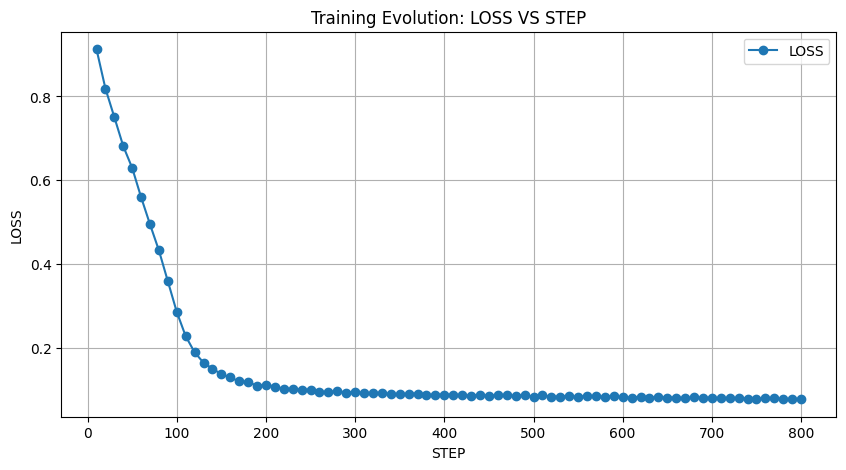

In [30]:
graph_training()

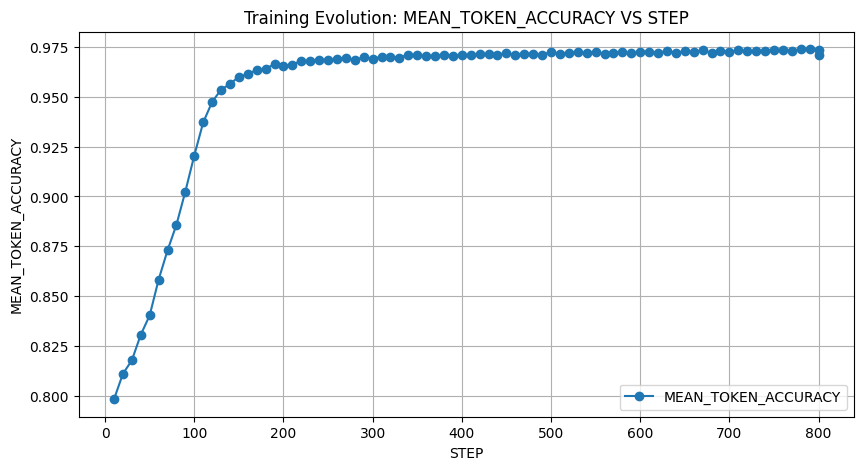

In [31]:
graph_training(y="mean_token_accuracy")